In [1]:
import sys
import joblib
import os
import scipy.io as sio
import numpy as np

from scipy.ndimage import binary_erosion
from scipy.spatial.distance import cdist
import cmocean

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Adjust the path to your project root directory where 'models' folder is located
project_root = os.path.abspath('../../../')  # or the relative path to your root from the notebook folder

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.models.cnn import CNN_AE
from src.models.pca import PCA_AE
from src.inputs import GaussianInputs
from src.optimizer import GPOptimizer, DeepGPOptimizer
from src.utils import *

In [3]:
project = 'fvcom'
tstep = 12120

In [4]:
xmin = -71.25+0.05
xmax = -69.75-0.05
ymin = 41.6+0.05
ymax = 42.8-0.05

grid_x = np.load(f'{project_root}/data/{project}/grid_x.npy')
grid_y = np.load(f'{project_root}/data/{project}/grid_y.npy')
grid_x_m, grid_y_m = sp_proj('forward', grid_x, grid_y,  'm')

u = np.load(f'{project_root}/data/{project}/u_interp.npy') 
v = np.load(f'{project_root}/data/{project}/v_interp.npy')
nt, n1, n2 = u.shape
mask = np.isnan(u[0,:,:])

u_fill, v_fill = u.copy(), v.copy()
u_fill[:, mask] = 0
v_fill[:, mask] = 0

In [5]:
seed = 1
np.random.seed(seed)

safe_mask = binary_erosion(~mask, structure=np.ones((15, 15)))  
yy, xx = np.where(safe_mask)
coords = np.array(list(zip(xx, yy)))

x0, y0 = -70.439467, 42.302897 # drifter release
dist_sq = (grid_x - x0)**2 + (grid_y - y0)**2
coords_0 = np.unravel_index(np.argmin(dist_sq), dist_sq.shape)

dt = 3600
ndays = 0.75
T = ndays*24*60*60
dts = [dt for _ in range(int(T / dt))]

num_traj = 5
selected = [coords[np.random.randint(len(coords))]]  # start with random point
# selected = [coords_0]  # start with drifter release point
for _ in range(num_traj - 1):
    dists = cdist(coords, np.array(selected))
    min_dists = dists.min(axis=1)
    next_idx = np.argmax(min_dists)
    selected.append(coords[next_idx])
selected = np.array(selected)

trajectories_m = {}
trajectories = {}

for traj_i in range(num_traj):
    x0_i = grid_x_m[selected[traj_i, 1], selected[traj_i, 0]]
    y0_i = grid_y_m[selected[traj_i, 1], selected[traj_i, 0]]

    traj_m = generate_trajectory(u_fill[tstep, :, :], v_fill[tstep, :, :], grid_x_m, grid_y_m, x0_i, y0_i, dts)
    trajectories_m[traj_i] = traj_m
    traj = np.array(sp_proj('inverse', traj_m[:,0], traj_m[:,1], 'm')).T
    trajectories[traj_i] = traj


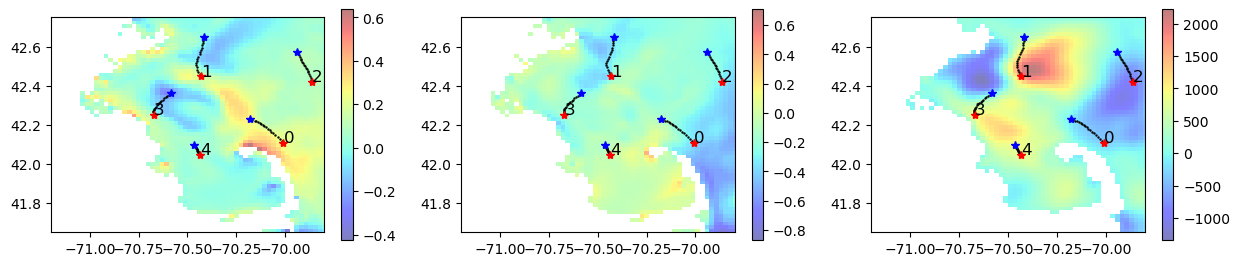

In [6]:
plt.figure(figsize=(15,3))

for i in range(3):
    if i == 0:
        plot_data = u[tstep,:,:]
    elif i == 1:
        plot_data = v[tstep,:,:]
    elif i == 2:
        plot_omega = vort_FVCOM(u[tstep,:,:], v[tstep,:,:], grid_x_m, grid_y_m) #s^-1
        plot_data = streamfunction_FVCOM(plot_omega, grid_x_m, grid_y_m) # m^2/s
        
    ax = plt.subplot(1,3,i+1)
    c = plot_trajectories(ax, plot_data, grid_x, grid_y, trajectories, xmin, xmax, ymin, ymax, cmap='jet')
    for traj_i in range(num_traj):
        plt.text(trajectories[traj_i][-1, 0], trajectories[traj_i][-1, 1], str(traj_i), fontsize=12, color='black')
    plt.colorbar(c)

In [7]:
latent_dim = 75
data, ae_scaler = transform_data_for_AE(u,v)

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# ae = CNN_AE(latent_dim=latent_dim)
# ae.load_state_dict(torch.load(f'{project_root}/src/models/checkpoints/{project}/cnn_model.pth'))
# ae.to(device)
# latent_space = get_latent_space(ae, data)

device = 'cpu'
ae = PCA_AE.load(f'{project_root}/src/models/checkpoints/{project}/pca_{latent_dim}_model.pkl')
latent_space = ae.encode(data).T

D = ae.decode

latent_distribution = gaussian_kde(latent_space)

In [8]:
acquisition_function = 'LCB'
optimizer = DeepGPOptimizer(trajectories_m, dts, trajectory_cost_function, D, latent_distribution, grid_x_m, grid_y_m, ae_scaler, device, acquisition_function, mask)

In [9]:
try:
    optimizer.optimize(n_iterations=50)
except Exception as e:
    print(f"Optimization failed with error: {e}")

Iteration 0: 143085.3318129953
Iteration 2: 114607.14994050446
Iteration 28: 111301.98809834107
Iteration 35: 74430.33471279943


In [10]:
z_opt, u_opt, v_opt, traj_opt_m = optimizer.get_optimal()

traj_opt = {}
for traj_i in range(num_traj):
    traj_opt[traj_i] = np.array(sp_proj('inverse', traj_opt_m[traj_i][:,0], traj_opt_m[traj_i][:,1], 'm')).T


In [11]:
u_plot = u[tstep, :, :]
v_plot = v[tstep, :, :]

w_plot = vort_FVCOM(u_plot, v_plot, grid_x_m, grid_y_m)
psi_plot = streamfunction_FVCOM(w_plot, grid_x_m, grid_y_m)

w_opt = vort_FVCOM(u_opt, v_opt, grid_x_m, grid_y_m)
psi_opt = streamfunction_FVCOM(w_opt, grid_x_m, grid_y_m)

costs = optimizer.Y
costs = optimizer.scaler_gp_y.inverse_transform(costs.reshape(-1, 1)).reshape(-1)
costs_sorted = np.sort(costs)

# k = len(np.argwhere(costs - costs_sorted[0] < 0.5))
k=3
z_top, u_top, v_top, traj_top_m = optimizer.get_top_k(k)
traj_top = []
for traj_k in range(k):
    traj_top.append({})
    for traj_i in range(num_traj):
        traj_top[traj_k][traj_i] = np.array(sp_proj('inverse', traj_top_m[traj_k][traj_i][:,0], traj_top_m[traj_k][traj_i][:,1], 'm')).T

w_top = np.array([vort_FVCOM(ui, vi, grid_x_m, grid_y_m) for ui, vi in zip(u_top, v_top)])
psi_top = np.array([streamfunction_FVCOM(wi, grid_x_m, grid_y_m) for wi in w_top])

u_mean = np.mean(np.array(u_top), axis=0)
v_mean = np.mean(np.array(v_top), axis=0)
w_mean = np.mean(np.array(w_top), axis=0)
psi_mean = np.mean(np.array(psi_top), axis=0)

w_plot = w_plot*1e6
w_opt = w_opt*1e6
w_mean = w_mean*1e6
w_top = w_top*1e6   

In [ ]:
vmin_u, vmax_u = -0.25, 0.25
vmin_v, vmax_v = -0.6, 0.6
psi_lim = 2500
psi_err_lim = 2000

vort_lim = 50
vort_err_lim = 30

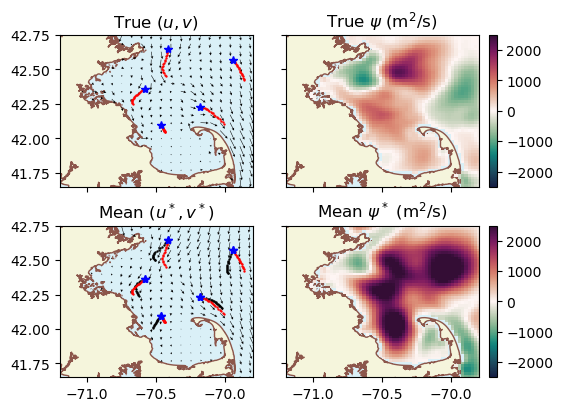

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(5.5, 4), constrained_layout=True, sharex=True, sharey=True)

for row in axes:
    for ax in row:
        ax.set_facecolor(np.array([218, 240, 247])/255)
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        mass.plot(ax=ax, color='beige', edgecolor='tab:brown')
        ax.set_aspect('equal', adjustable='box')

# Plot true quiver
axes[0,0].quiver(grid_x[::3, ::3], grid_y[::3, ::3], u_plot[::3, ::3], v_plot[::3, ::3], color='k', headwidth=5)
axes[0,0].set_title('True $(u, v)$')
plt.subplot(2,2,1)
plot_trajectories_lines(trajectories, color='red')

# Plot mean quiver
axes[1,0].quiver(grid_x[::3, ::3], grid_y[::3, ::3], u_mean[::3, ::3], v_mean[::3, ::3], color='k', headwidth=5)
plt.subplot(2,2,3)
plot_trajectories_lines(traj_opt, color='black')
plot_trajectories_lines(trajectories, color='red')
axes[1,0].set_title('Mean $(u^*, v^*)$')

# Plot true psi
c1 = axes[0,1].pcolormesh(grid_x, grid_y, psi_plot, cmap=cmocean.cm.curl, vmin=-psi_lim, vmax=psi_lim)
axes[0,1].set_title('True $\psi$ (m$^2$/s)')
plt.colorbar(c1, ax=axes[0,1])

# Plot mean psi
c2 = axes[1,1].pcolormesh(grid_x, grid_y, psi_opt, cmap=cmocean.cm.curl, vmin=-psi_lim, vmax=psi_lim)
axes[1,1].set_title('Mean $\psi^*$ (m$^2$/s)')
plt.colorbar(c2, ax=axes[1,1])



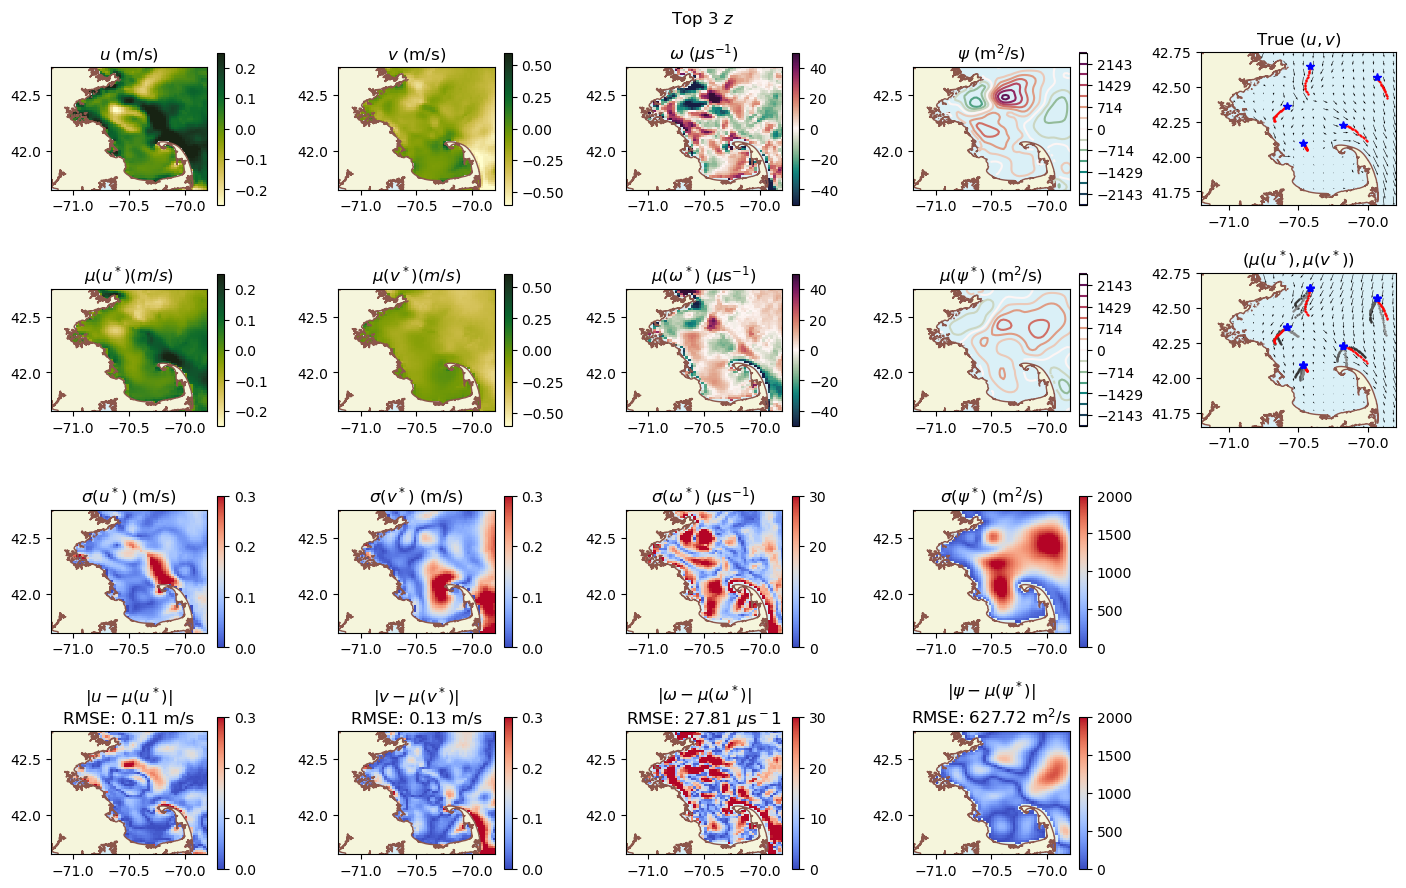

In [ ]:
fig = plt.figure(figsize=(14, 9))

# Define configurations for each case
configurations = {
    0: {'plot_data': u_plot, 'cmap': cmocean.cm.speed, 'vmin': vmin_u, 'vmax': vmax_u, 'ttl': '$u$ (m/s)'},
    1: {'plot_data': v_plot, 'cmap': cmocean.cm.speed, 'vmin': vmin_v, 'vmax': vmax_v, 'ttl': '$v$ (m/s)'},
    2: {'plot_data': w_plot, 'cmap': cmocean.cm.curl, 'vmin': -vort_lim, 'vmax': vort_lim, 'ttl': '$\omega$ ($\mu$s$^{-1}$)'},
    3: {'plot_data': psi_plot, 'cmap': cmocean.cm.curl, 'vmin': -psi_lim, 'vmax': psi_lim, 'ttl': '$\psi$ (m$^2$/s)'},
    4: {'ttl': 'True $(u,v)$'},
    5: {'plot_data': u_mean, 'cmap': cmocean.cm.speed, 'vmin': vmin_u, 'vmax': vmax_u, 'ttl': '$\mu(u^*) (m/s)$'},
    6: {'plot_data': v_mean, 'cmap': cmocean.cm.speed, 'vmin': vmin_v, 'vmax': vmax_v, 'ttl': '$\mu(v^*) (m/s)$'},
    7: {'plot_data': w_mean , 'cmap': cmocean.cm.curl, 'vmin': -vort_lim, 'vmax': vort_lim, 'ttl': '$\mu(\omega^*)$ ($\mu$s$^{-1}$)'},
    8: {'plot_data': psi_mean, 'cmap': cmocean.cm.curl, 'vmin': -psi_lim, 'vmax': psi_lim, 'ttl': '$\mu(\psi^*)$ (m$^2$/s)'},
    9: {'ttl': '$(\mu(u^*),\mu(v^*))$'},
    10: {'plot_data': np.std(np.array(u_top), axis=0), 'cmap': 'coolwarm', 'vmin': 0, 'vmax': 0.3, 'ttl': '$\sigma(u^*)$ (m/s)'},
    11: {'plot_data': np.std(np.array(v_top), axis=0), 'cmap': 'coolwarm', 'vmin': 0, 'vmax': 0.3, 'ttl': '$\sigma(v^*)$ (m/s)'},
    12: {'plot_data': np.std(np.array(w_top), axis=0) , 'cmap': 'coolwarm', 'vmin': 0, 'vmax': vort_err_lim, 'ttl': '$\sigma(\omega^*)$ ($\mu$s$^{-1}$)'},
    13: {'plot_data': np.std(np.array(psi_top), axis=0), 'cmap': 'coolwarm', 'vmin': 0, 'vmax': psi_err_lim, 'ttl': '$\sigma(\psi^*)$ (m$^2$/s)'},
    15: {'plot_data': np.abs(u_plot - u_mean), 'cmap': 'coolwarm', 'vmin': 0, 'vmax': 0.3, 'ttl': '|$u - \mu(u^*)|$\nRMSE: {:.2f} m/s'.format(np.sqrt(np.nanmean((u_plot - u_mean)**2)))},
    16: {'plot_data': np.abs(v_plot - v_mean), 'cmap': 'coolwarm', 'vmin': 0, 'vmax': 0.3, 'ttl': '$|v - \mu(v^*)|$\nRMSE: {:.2f} m/s'.format(np.sqrt(np.nanmean((v_plot - v_mean)**2)))},
    17: {'plot_data': np.abs((w_plot - w_mean)), 'cmap': 'coolwarm', 'vmin': 0, 'vmax': vort_err_lim, 'ttl': f'$|\omega - \mu(\omega^*)|$\nRMSE: {np.sqrt(np.nanmean((w_plot - w_mean)**2)):.2f} $\mu$s$^{-1}$'},
    18: {'plot_data': np.abs(psi_plot - psi_mean), 'cmap': 'coolwarm', 'vmin': 0, 'vmax': psi_err_lim, 'ttl': '$|\psi - \mu(\psi^*)|$\nRMSE: {:.2f} m$^2$/s'.format(np.sqrt(np.nanmean((psi_plot - psi_mean)**2)))}
}

for i in range(20):
    if i in [14, 19]:
        continue

    ax = plt.subplot(4, 5, i + 1)
    ax.set_facecolor(np.array([218, 240, 247])/255)

    if i in configurations:
        config = configurations[i]
        if i in [4, 9]:
            if i == 4:
                plt.quiver(grid_x[::3, ::3], grid_y[::3, ::3], u_plot[::3, ::3], v_plot[::3, ::3], color='k')
                plot_trajectories_lines(trajectories, color='red')
            elif i == 9:
                plt.quiver(grid_x[::3, ::3], grid_y[::3, ::3], u_mean[::3, ::3], v_mean[::3, ::3], color='k')
                for j, traj in enumerate(traj_top):
                    plot_trajectories_lines(traj, color=str(0.2 + 0.16 * j))
                plot_trajectories_lines(trajectories, color='red')
        elif i in [3, 8]:
            levels = np.linspace(config['vmin'], config['vmax'], 15)
            c = plt.contour(grid_x, grid_y, config['plot_data'], levels=levels, cmap=config['cmap'], vmin=config['vmin'], vmax=config['vmax'])
            plt.colorbar(c, shrink=0.9)
        else:
            c = plt.pcolormesh(grid_x, grid_y, config['plot_data'], cmap=config['cmap'], vmin=config['vmin'], vmax=config['vmax'])
            plt.colorbar(c, shrink=0.9)
        plt.title(config['ttl'])

    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    mass.plot(ax=ax, color='beige', edgecolor='tab:brown')
    ax.set_aspect('equal', adjustable='box')

plt.suptitle(f'Top {k} $z$')
plt.tight_layout(pad=0.5)
# plt.savefig(f'FVCOM_Figures/FVCOM_optimization_{tstep}_top{k}_uncertainty_{latent_dim}_{acquisition_function}.png', dpi=300, bbox_inches='tight')


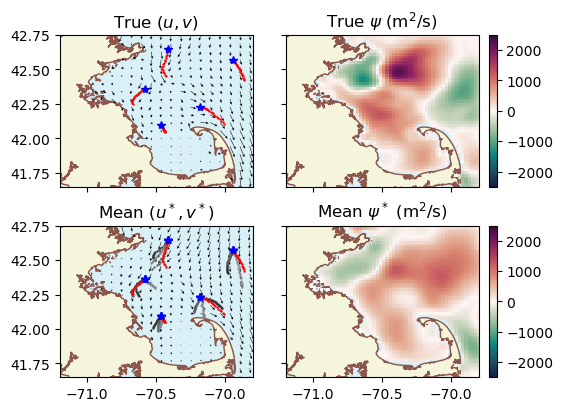

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(5.5, 4), constrained_layout=True, sharex=True, sharey=True)

for row in axes:
    for ax in row:
        ax.set_facecolor(np.array([218, 240, 247])/255)
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        mass.plot(ax=ax, color='beige', edgecolor='tab:brown')
        ax.set_aspect('equal', adjustable='box')

# Plot true quiver
axes[0,0].quiver(grid_x[::3, ::3], grid_y[::3, ::3], u_plot[::3, ::3], v_plot[::3, ::3], color='k', headwidth=5)
axes[0,0].set_title('True $(u, v)$')
plt.subplot(2,2,1)
plot_trajectories_lines(trajectories, color='red')

# Plot mean quiver
axes[1,0].quiver(grid_x[::3, ::3], grid_y[::3, ::3], u_mean[::3, ::3], v_mean[::3, ::3], color='k', headwidth=5)
plt.subplot(2,2,3)
for j, traj in enumerate(traj_top):
    plot_trajectories_lines(traj, color=str(0.2 + 0.16 * j))
plot_trajectories_lines(trajectories, color='red')
axes[1,0].set_title('Mean $(u^*, v^*)$')

# Plot true psi
c1 = axes[0,1].pcolormesh(grid_x, grid_y, psi_plot, cmap=cmocean.cm.curl, vmin=-psi_lim, vmax=psi_lim)
axes[0,1].set_title('True $\psi$ (m$^2$/s)')
plt.colorbar(c1, ax=axes[0,1])

# Plot mean psi
c2 = axes[1,1].pcolormesh(grid_x, grid_y, psi_mean, cmap=cmocean.cm.curl, vmin=-psi_lim, vmax=psi_lim)
axes[1,1].set_title('Mean $\psi^*$ (m$^2$/s)')
plt.colorbar(c2, ax=axes[1,1])

